In [6]:
# analysis of compiled radstats
# joint pdf of (cloud amount) vs (OmF, OmFnbc) 
# initial built: 2024/12/28

# 2025/01/07
# Note: this notebook has been transformed into a python script
# except for (1) cloud-cloud omf and (2) model vs obs cloud PDF 

In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [3]:
instrument = 'amsua'
channel    = 'ch1'
expid      = 'full_clr_cld'
#expid      = 'full_CTRL'
stdev_from = f'OmF_{expid}'
predictor  = 'sym_cld'


expid_short = {'full_clr_cld': 'clr & cld', 
               'full_CTRL':    'CTRL'}

if instrument == 'amsua':
    if channel in ('ch1','ch3'):
        vmin = -30; vmax = 30;
    elif channel in ('ch2'):
        vmin = -45; vmax = 45;
    elif channel in ('ch4'):
        vmin = -7;  vmax = 7;
    elif channel in ('ch5'):
        vmin = -3;  vmax = 3;
    elif channel in ('ch15'):
        vmin = -40; vmax = 40;
            
elif instrument == 'atms':
    if channel in ('ch16'):
        vmin = -30; vmax = 30;
    elif channel in ('ch17','ch18'):
        vmin = -25; vmax = 25;
    elif channel in ('ch19','ch20'):
        vmin = -15; vmax = 15;
    elif channel in ('ch21','ch22'):
        vmin = -20; vmax = 20;
        
    

In [4]:
### read omf csv (large file!)
fn = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/compile_radstats/csv_files/{expid}/omf_stats_{instrument}_{channel}_2022062000_2022081000.csv'
df = pd.read_csv(fn)

# screen the data:
dfs = df[abs(df['omf_ges']) < 1e3]

In [5]:
### sort the data based on regions
regions=['sea']
lats   =['Global']

#regions=['land','sea']
#lats   =['Global','90S-60S','60S-40S','40S-20S','20S-0','0-20N','20N-40N','40N-60N','60N-90N']

adf={} # "a"nalysis "d"ata "f"rame

for rg in regions:
    adf[rg] = {}  # Initialize the nested dictionary for each experiment
    if rg == 'land':
        dftmp = dfs.loc[ dfs['fland']>=0.99 ]
    elif rg == 'sea':
        dftmp = dfs.loc[ dfs['fwater']>=0.99 ]
        
    for lat in lats:
        if lat == 'Global':
            adf[rg][lat] = dftmp
        elif lat == '90S-60S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-60) & (dftmp['lat']>-90) ]
        elif lat == '60S-40S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-40) & (dftmp['lat']>-60) ]
        elif lat == '40S-20S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-20) & (dftmp['lat']>-40) ]
        elif lat == '20S-0':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=0) & (dftmp['lat']>-20) ]
        elif lat == '0-20N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=20) & (dftmp['lat']>0) ]
        elif lat == '20N-40N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=40) & (dftmp['lat']>20) ]
        elif lat == '40N-60N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=60) & (dftmp['lat']>40) ]
        elif lat == '60N-90N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=90) & (dftmp['lat']>60) ]

In [6]:
dftmp = adf['sea']['Global']

/tmp/ipykernel_230308/4013135049.py:38: RuntimeWarning: divide by zero encountered in log10
  input_data = - np.log10(hist*dA)
/tmp/ipykernel_230308/4013135049.py:47: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)


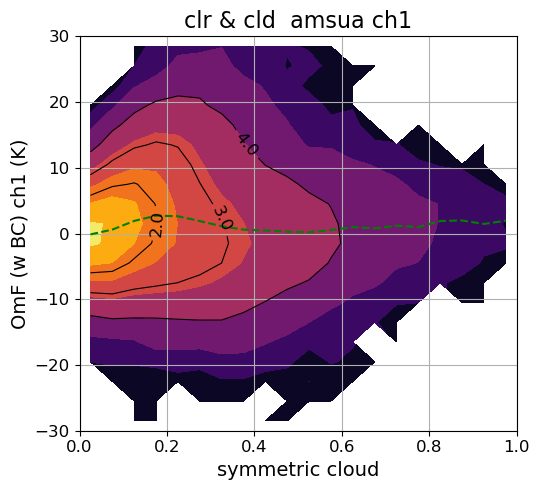

In [13]:
# Plot OmF vs symmetric cloud

save_fig = False
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/tables/{expid}/jointpdf_cloud_omf'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

sym_cloud = 0.5*(dftmp['clw_bg_nobc_ges'] + dftmp['clw_obs'])

x_edges = np.linspace(0, 1, 21)
y_edges = np.linspace(vmin, vmax, 21)
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA = dx*dy

x = sym_cloud
y = dftmp['omf_ges']

# calculate the conditional mean (takes time...)
xx = np.linspace(0,1,21)
xxc = 0.5*(xx[:-1] + xx[1:])
yyc = np.zeros_like(xxc)
for i in range(len(xxc)):
    xdftmp = dftmp.loc[ (x>=xx[i]) & (x<xx[i+1]) ]
    yyc[i] = xdftmp['omf_ges'].mean()


hist, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_edges, y_edges], density=True)

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

# Mask values >= 6
input_data = - np.log10(hist*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(5.5,5))
contour1=ax.contourf(xx, yy, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)

# plot the conditional mean
ax.plot(xxc,yyc, color='green', linestyle='--')

# Add labels to contour lines
ax.clabel(contour_lines, inline=True, fontsize=12, fmt="%.1f")

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('symmetric cloud',fontsize=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(f'OmF (w BC) {channel} (K)',fontsize=14)
ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(f'{expid_short[expid]}  {instrument} {channel}',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/omf_sym_{instrument}_{channel}.png', dpi=200, bbox_inches='tight')

/tmp/ipykernel_230308/3159871692.py:35: RuntimeWarning: divide by zero encountered in log10
  input_data = - np.log10(hist*dA)
/tmp/ipykernel_230308/3159871692.py:44: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)


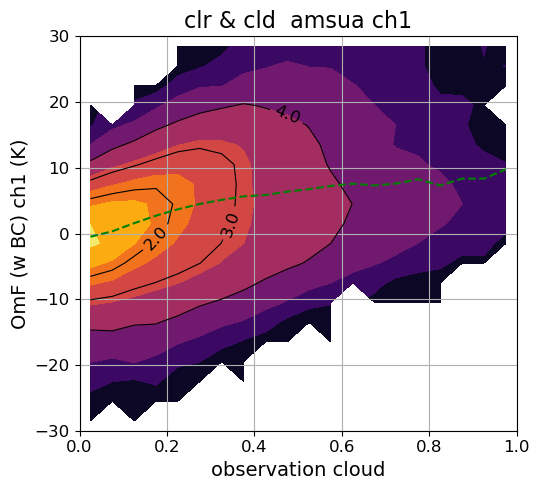

In [14]:
# Plot OmF vs observation cloud

save_fig = False
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/tables/{expid}/jointpdf_cloud_omf'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

x_edges = np.linspace(0, 1, 21)  
y_edges = np.linspace(vmin, vmax, 21)
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA = dx*dy

x = dftmp['clw_obs']
y = dftmp['omf_ges']

# calculate the conditional mean (takes time...)
xx = np.linspace(0,1,21)
xxc = 0.5*(xx[:-1] + xx[1:])
yyc = np.zeros_like(xxc)
for i in range(len(xxc)):
    xdftmp = dftmp.loc[ (x>=xx[i]) & (x<xx[i+1]) ]
    yyc[i] = xdftmp['omf_ges'].mean()

hist, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_edges, y_edges], density=True)

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

# Mask values >= 6
input_data = - np.log10(hist*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(5.5,5))
contour1=ax.contourf(xx, yy, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)

# Add labels to contour lines
ax.clabel(contour_lines, inline=True, fontsize=12, fmt="%.1f")

# plot the conditional mean
ax.plot(xxc,yyc, color='green', linestyle='--')

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('observation cloud',fontsize=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(f'OmF (w BC) {channel} (K)',fontsize=14)
ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(f'{expid_short[expid]}  {instrument} {channel}',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/omf_obs_{instrument}_{channel}.png', dpi=200, bbox_inches='tight')

/tmp/ipykernel_230308/4074634889.py:35: RuntimeWarning: divide by zero encountered in log10
  input_data = - np.log10(hist*dA)
/tmp/ipykernel_230308/4074634889.py:44: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)


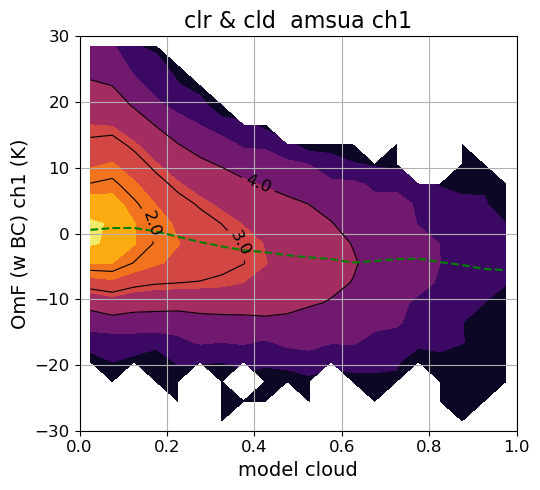

In [15]:
# Plot OmF vs model cloud

save_fig = False
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/tables/{expid}/jointpdf_cloud_omf'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

x_edges = np.linspace(0, 1, 21)  
y_edges = np.linspace(vmin, vmax, 21)
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA = dx*dy

x = dftmp['clw_bg_nobc_ges']
y = dftmp['omf_ges']

# calculate the conditional mean (takes time...)
xx = np.linspace(0,1,21)
xxc = 0.5*(xx[:-1] + xx[1:])
yyc = np.zeros_like(xxc)
for i in range(len(xxc)):
    xdftmp = dftmp.loc[ (x>=xx[i]) & (x<xx[i+1]) ]
    yyc[i] = xdftmp['omf_ges'].mean()

hist, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_edges, y_edges], density=True)

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

# Mask values >= 6
input_data = - np.log10(hist*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(5.5,5))
contour1=ax.contourf(xx, yy, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)

# Add labels to contour lines
ax.clabel(contour_lines, inline=True, fontsize=12, fmt="%.1f")

# plot the conditional mean
ax.plot(xxc,yyc, color='green', linestyle='--')

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('model cloud',fontsize=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(f'OmF (w BC) {channel} (K)',fontsize=14)
ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(f'{expid_short[expid]}  {instrument} {channel}',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/omf_model_{instrument}_{channel}.png', dpi=200, bbox_inches='tight')

/tmp/ipykernel_230308/4059303371.py:37: RuntimeWarning: divide by zero encountered in log10
  input_data = - np.log10(hist*dA)
/tmp/ipykernel_230308/4059303371.py:46: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)


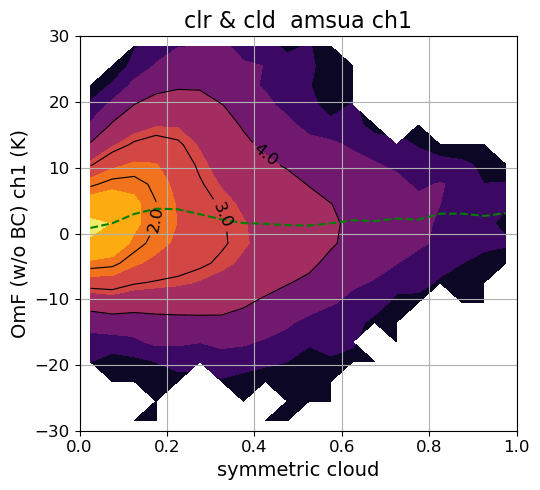

In [16]:
# Plot OmFnbc vs symmetric cloud

save_fig = False
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/tables/{expid}/jointpdf_cloud_omf'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

sym_cloud = 0.5*(dftmp['clw_bg_nobc_ges'] + dftmp['clw_obs'])

x_edges = np.linspace(0, 1, 21)  
y_edges = np.linspace(vmin, vmax, 21)
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA = dx*dy

x = sym_cloud
y = dftmp['omfnbc_ges']

# calculate the conditional mean (takes time...)
xx = np.linspace(0,1,21)
xxc = 0.5*(xx[:-1] + xx[1:])
yyc = np.zeros_like(xxc)
for i in range(len(xxc)):
    xdftmp = dftmp.loc[ (x>=xx[i]) & (x<xx[i+1]) ]
    yyc[i] = xdftmp['omfnbc_ges'].mean()

hist, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_edges, y_edges], density=True)

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

# Mask values >= 6
input_data = - np.log10(hist*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(5.5,5))
contour1=ax.contourf(xx, yy, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)

# Add labels to contour lines
ax.clabel(contour_lines, inline=True, fontsize=12, fmt="%.1f")

# plot the conditional mean
ax.plot(xxc,yyc, color='green', linestyle='--')

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('symmetric cloud',fontsize=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(f'OmF (w/o BC) {channel} (K)',fontsize=14)
ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(f'{expid_short[expid]}  {instrument} {channel}',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/omfnbc_sym_{instrument}_{channel}.png', dpi=200, bbox_inches='tight')

/tmp/ipykernel_230308/3249676314.py:35: RuntimeWarning: divide by zero encountered in log10
  input_data = - np.log10(hist*dA)
/tmp/ipykernel_230308/3249676314.py:44: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)


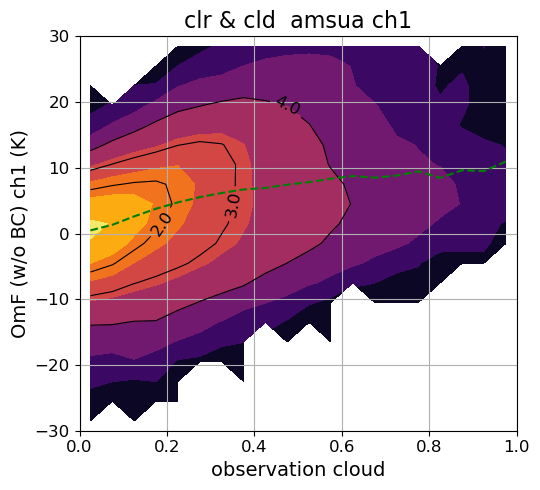

In [17]:
# Plot OmFnbc vs observation cloud

save_fig = False
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/tables/{expid}/jointpdf_cloud_omf'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

x_edges = np.linspace(0, 1, 21)  
y_edges = np.linspace(vmin, vmax, 21)
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA = dx*dy

x = dftmp['clw_obs']
y = dftmp['omfnbc_ges']

# calculate the conditional mean (takes time...)
xx = np.linspace(0,1,21)
xxc = 0.5*(xx[:-1] + xx[1:])
yyc = np.zeros_like(xxc)
for i in range(len(xxc)):
    xdftmp = dftmp.loc[ (x>=xx[i]) & (x<xx[i+1]) ]
    yyc[i] = xdftmp['omfnbc_ges'].mean()

hist, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_edges, y_edges], density=True)

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

# Mask values >= 6
input_data = - np.log10(hist*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(5.5,5))
contour1=ax.contourf(xx, yy, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)

# Add labels to contour lines
ax.clabel(contour_lines, inline=True, fontsize=12, fmt="%.1f")

# plot the conditional mean
ax.plot(xxc,yyc, color='green', linestyle='--')

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('observation cloud',fontsize=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(f'OmF (w/o BC) {channel} (K)',fontsize=14)
ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(f'{expid_short[expid]}  {instrument} {channel}',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/omfnbc_obs_{instrument}_{channel}.png', dpi=200, bbox_inches='tight')

/tmp/ipykernel_230308/1667438922.py:35: RuntimeWarning: divide by zero encountered in log10
  input_data = - np.log10(hist*dA)
/tmp/ipykernel_230308/1667438922.py:44: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)


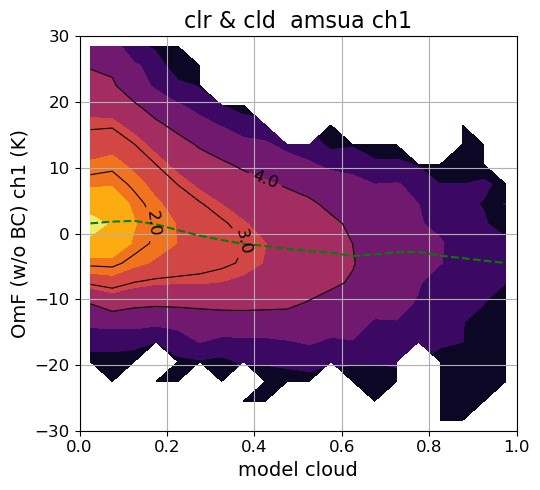

In [18]:
# Plot OmFnbc vs model cloud

save_fig = False
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/tables/{expid}/jointpdf_cloud_omf'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

x_edges = np.linspace(0, 1, 21)  
y_edges = np.linspace(vmin, vmax, 21)
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA = dx*dy

x = dftmp['clw_bg_nobc_ges']
y = dftmp['omfnbc_ges']

# calculate the conditional mean (takes time...)
xx = np.linspace(0,1,21)
xxc = 0.5*(xx[:-1] + xx[1:])
yyc = np.zeros_like(xxc)
for i in range(len(xxc)):
    xdftmp = dftmp.loc[ (x>=xx[i]) & (x<xx[i+1]) ]
    yyc[i] = xdftmp['omfnbc_ges'].mean()

hist, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_edges, y_edges], density=True)

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

# Mask values >= 6
input_data = - np.log10(hist*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(5.5,5))
contour1=ax.contourf(xx, yy, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)

# Add labels to contour lines
ax.clabel(contour_lines, inline=True, fontsize=12, fmt="%.1f")

# plot the conditional mean
ax.plot(xxc,yyc, color='green', linestyle='--')

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('model cloud',fontsize=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(f'OmF (w/o BC) {channel} (K)',fontsize=14)
ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(f'{expid_short[expid]}  {instrument} {channel}',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/omfnbc_model_{instrument}_{channel}.png', dpi=200, bbox_inches='tight')

Directory '/home/Chih-Chi.Hu/python_codes/figures/tables/full_clr_cld/jointpdf_model_obs_cloud' created.


/tmp/ipykernel_3557171/1939161886.py:28: RuntimeWarning: divide by zero encountered in log10
  input_data = - np.log10(hist*dA)
/tmp/ipykernel_3557171/1939161886.py:37: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)


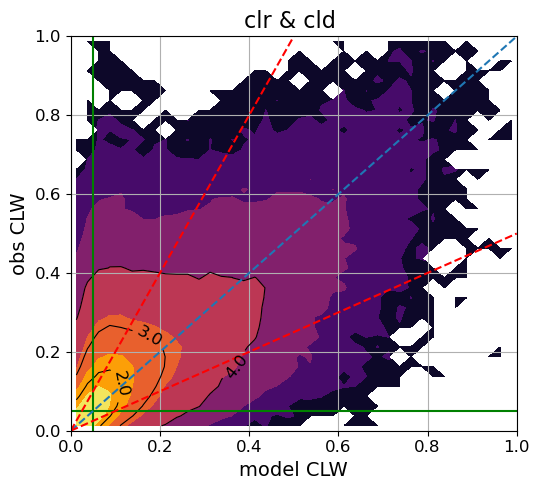

In [20]:
# model cloud vs observation cloud
# symmetric cloud vs OmF cloud

save_fig = True
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/tables/{expid}/jointpdf_model_obs_cloud'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

x_edges = np.linspace( 0, 1, 41)  
y_edges = np.linspace( 0, 1, 41)
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA = dx*dy

x = dftmp['clw_bg_nobc_ges']
y = dftmp['clw_obs'] 

hist, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_edges, y_edges], density=True)

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

# Mask values >= 6
input_data = - np.log10(hist*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(5.5,5))
contour1=ax.contourf(xx, yy, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)

# Add labels to contour lines
ax.clabel(contour_lines, inline=True, fontsize=12, fmt="%.1f")

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('model CLW',fontsize=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(f'obs CLW',fontsize=14)

ax.axvline(0.05, color='green')
ax.axhline(0.05, color='green')

ax.plot([0,1], [0,1], linestyle='--')
ax.plot([0,1], [0,0.5], linestyle='--', color='red')
ax.plot([0,1], [0,2], linestyle='--', color='red')



ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(f'{expid_short[expid]} ',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/jointpdf_model_obs_cloud_{expid}.png', dpi=200, bbox_inches='tight')

/tmp/ipykernel_2655291/2428172570.py:29: RuntimeWarning: divide by zero encountered in log10
  input_data = - np.log10(hist*dA)
/tmp/ipykernel_2655291/2428172570.py:38: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)


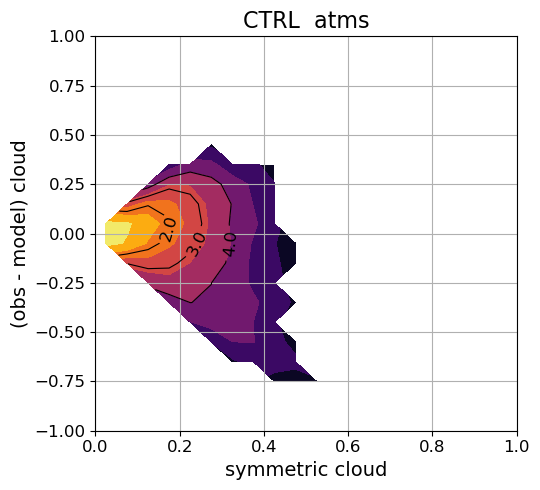

In [180]:
# symmetric cloud vs OmF cloud

save_fig = True
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/tables/{expid}/jointpdf_cloud_cloudomf'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

x_edges = np.linspace( 0, 1, 21)  
y_edges = np.linspace(-1, 1, 21)
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA = dx*dy

sym_cloud = 0.5*(dftmp['clw_bg_nobc_ges'] + dftmp['clw_obs'])

x = sym_cloud
y = dftmp['clw_obs'] - dftmp['clw_bg_nobc_ges']

hist, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_edges, y_edges], density=True)

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

# Mask values >= 6
input_data = - np.log10(hist*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(5.5,5))
contour1=ax.contourf(xx, yy, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)

# Add labels to contour lines
ax.clabel(contour_lines, inline=True, fontsize=12, fmt="%.1f")

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('symmetric cloud',fontsize=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(f'(obs - model) cloud',fontsize=14)
ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(f'{expid_short[expid]}  {instrument}',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/cloudomf_symcloud_{instrument}_{expid}.png', dpi=200, bbox_inches='tight')

/tmp/ipykernel_2655291/2305321804.py:29: RuntimeWarning: divide by zero encountered in log10
  input_data = - np.log10(hist*dA)
/tmp/ipykernel_2655291/2305321804.py:38: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)


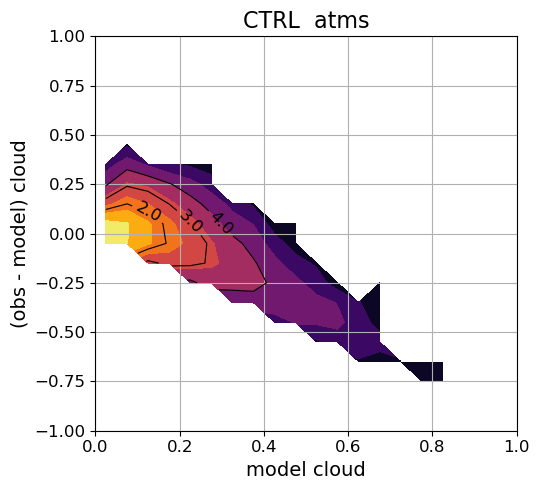

In [120]:
# model cloud vs OmF cloud

save_fig = True
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/tables/{expid}/jointpdf_cloud_cloudomf'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

x_edges = np.linspace( 0, 1, 21)  
y_edges = np.linspace(-1, 1, 21)
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA = dx*dy

sym_cloud = 0.5*(dftmp['clw_bg_nobc_ges'] + dftmp['clw_obs'])

x = dftmp['clw_bg_nobc_ges']
y = dftmp['clw_obs'] - dftmp['clw_bg_nobc_ges']

hist, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_edges, y_edges], density=True)

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

# Mask values >= 6
input_data = - np.log10(hist*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(5.5,5))
contour1=ax.contourf(xx, yy, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)

# Add labels to contour lines
ax.clabel(contour_lines, inline=True, fontsize=12, fmt="%.1f")

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('model cloud',fontsize=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(f'(obs - model) cloud',fontsize=14)
ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(f'{expid_short[expid]}  {instrument}',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/cloudomf_modelcloud_{instrument}_{expid}.png', dpi=200, bbox_inches='tight')

/tmp/ipykernel_2655291/2004722868.py:29: RuntimeWarning: divide by zero encountered in log10
  input_data = - np.log10(hist*dA)
/tmp/ipykernel_2655291/2004722868.py:38: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)


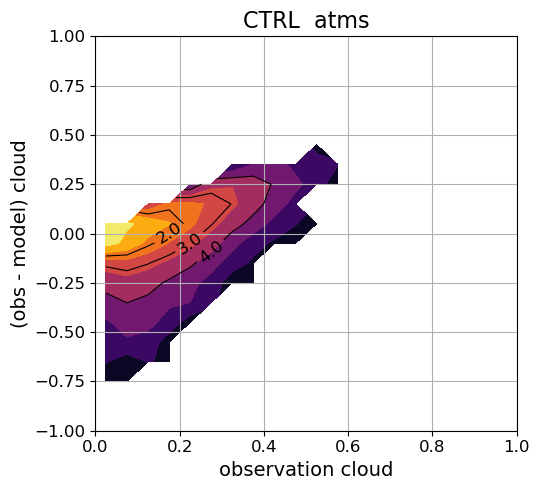

In [121]:
# obs cloud vs OmF cloud

save_fig = True
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/tables/{expid}/jointpdf_cloud_cloudomf'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

x_edges = np.linspace( 0, 1, 21)  
y_edges = np.linspace(-1, 1, 21)
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA = dx*dy

sym_cloud = 0.5*(dftmp['clw_bg_nobc_ges'] + dftmp['clw_obs'])

x = dftmp['clw_obs']
y = dftmp['clw_obs'] - dftmp['clw_bg_nobc_ges']

hist, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_edges, y_edges], density=True)

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

# Mask values >= 6
input_data = - np.log10(hist*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(5.5,5))
contour1=ax.contourf(xx, yy, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)

# Add labels to contour lines
ax.clabel(contour_lines, inline=True, fontsize=12, fmt="%.1f")

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('observation cloud',fontsize=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(f'(obs - model) cloud',fontsize=14)
ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(f'{expid_short[expid]}  {instrument}',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/cloudomf_obscloud_{instrument}_{expid}.png', dpi=200, bbox_inches='tight')

In [56]:
dx = x_edges[1] - x_edges[0] 
dy = y_edges[1] - y_edges[0] 

In [57]:
dx


0.02

In [58]:
dy

0.6000000000000014